In [1]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import matplotlib as mpl
import seaborn as sns
import plotly.express as px
import folium
import json

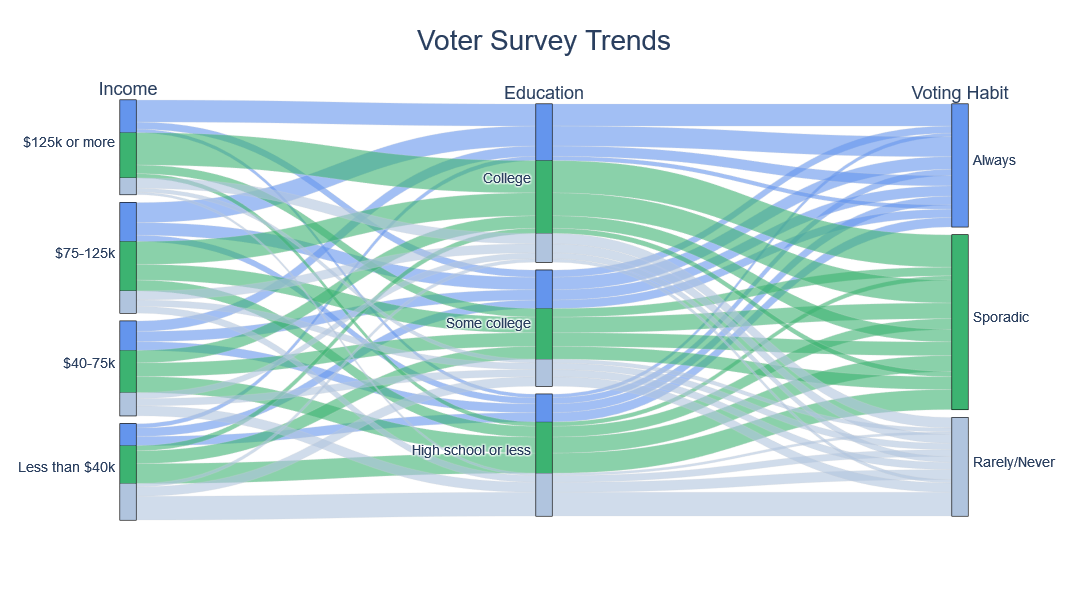

In [32]:
df = pd.read_csv('vote_subset.csv')
df = df[['voter_cat', 'education', 'income_cat']] 
df['voter_cat_num'] = df['voter_cat'].map({'always': 0, 'sporadic': 1, 'rarely/never': 2})
df['voter_cat'] = df['voter_cat'].replace({'sporadic': 'Sporadic', 'always': 'Always', 'rarely/never': 'Rarely/Never'})

# figure
income_dim = go.parcats.Dimension(
    values=df['income_cat'],
    categoryorder = 'array',
    categoryarray = ['$125k or more', '$75-125k', '$40-75k', 'Less than $40k'],
    label='Income')
education_dim = go.parcats.Dimension(
    values=df['education'],
    categoryorder = 'array',
    categoryarray = ['College', 'Some college', 'High school or less'],
    label='Education')
voter_dim = go.parcats.Dimension(
    values=df['voter_cat'],
    categoryorder = 'array',
    categoryarray = ['Always', 'Sporadic', 'Rarely/Never'],
    label = 'Voting Habit')
color = df.voter_cat_num
colorscale = [[0, 'cornflowerblue'], [0.5, 'mediumseagreen'], [1, 'lightsteelblue']]
fig = go.Figure(data = [go.Parcats(dimensions=[income_dim, education_dim, voter_dim],
                                  line = {'color':color, 'colorscale':colorscale, 'shape':'hspline'},
                                  #hoverinfo = 'count+probability',
                                  labelfont = {'size':18, 'family': 'Arial'},
                                  tickfont = {'size':14, 'family': 'Arial'})])

fig.update_layout(
    title = {'text': 'Voter Survey Trends', 'font': {'size': 28, 'family': 'Arial'}, 'x':0.5, 'xanchor':'center'},
    height=600,
    width=1100,
    hoverlabel=dict(font=dict(family='Arial', size=16))
)

fig.write_html('categories.html')
fig.write_image('categories.png')
fig.show()

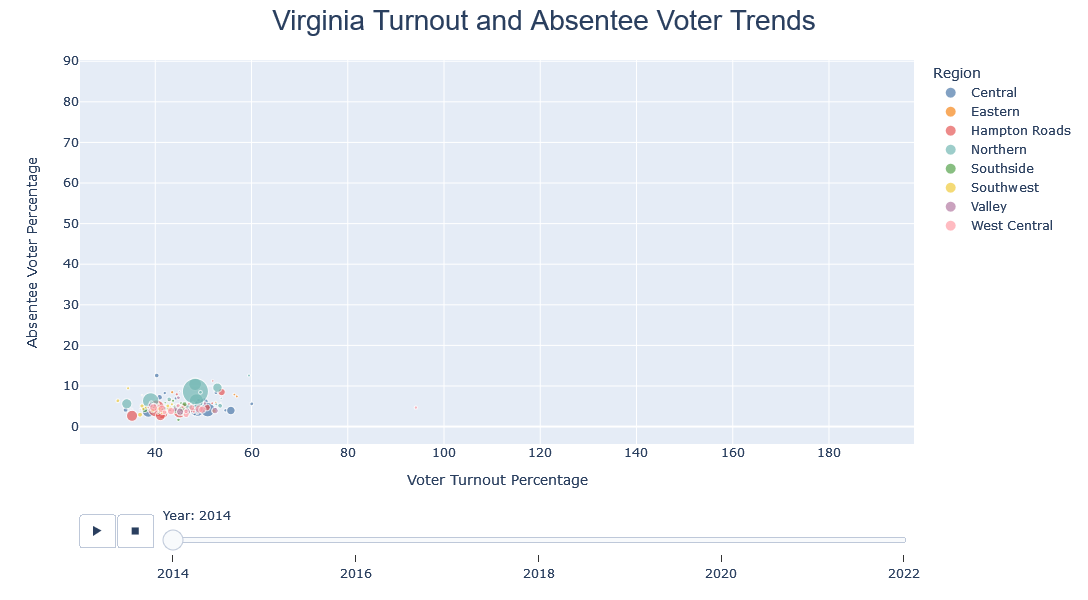

In [34]:
df = pd.read_csv('election_data.csv')
df.rename(columns={'region': 'Region'}, inplace=True)
df['pct_absentee'] = (df['absentee_ballots']/df['TotalVoteTurnout'])*100
df['pct_turnout'] = (df['TotalVoteTurnout']/df['ActiveRegisteredVoters'])*100
df = df.sort_values(by='year') #the animation frame was generating in the wrong order, this fixes it
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=['pct_turnout'])
df['Region'] = df['Region'].replace({'eastern': 'Eastern', 'northern': 'Northern', 'central':'Central', 'valley':'Valley','hampton_roads':'Hampton Roads', 'southside':'Southside', 'southwest':'Southwest', 'west_central':'West Central'})

min_x,max_x = df['pct_turnout'].min(), df['pct_turnout'].max()
min_y,max_y = df['pct_absentee'].min(), df['pct_absentee'].max()
min_x = min_x - 0.05*(max_x - min_x)
min_y = min_y - 0.05*(max_y - min_y)
max_x = max_x + 0.05*(max_x - min_x)
max_y = max_y + 0.05*(max_y - min_y)

fig = px.scatter(df, x='pct_turnout', y='pct_absentee',
                 color='Region',
                 color_discrete_sequence=px.colors.qualitative.T10,
                 size='TotalRegisteredVoters', size_max=20,
                 hover_name='locality',
                 hover_data={'Region': False, 'year': False},
                 labels={'pct_absentee': 'Absentee Voter Percentage', 'pct_turnout': 'Voter Turnout Percentage'},
                 animation_frame='year',
                 range_x=[min_x, max_x], range_y=[min_y, max_y],
                 height=600, width = 1100,
                 category_orders={'Region': sorted(df['Region'].unique())}
)
fig.update_traces(hovertemplate='<br>'.join([
    '%{hovertext}',
    'Turnout: %{x:.2f}%',
    'Absentee: %{y:.2f}%',
    'Total Registered Voters: %{marker.size}',
    '<extra></extra>'
]))

fig.update_layout(
    sliders=[{"currentvalue": {"prefix": "Year: ",'xanchor':'left'}}],
    title = {'text': 'Virginia Turnout and Absentee Voter Trends', 'font': {'size': 28, 'family': 'Arial'}, 'x':0.5, 'xanchor':'center'})
fig.write_html('bubble.html')
fig.write_image('bubbble.png')
fig.show()

In [25]:
with open('counties_VA.json') as f:
    county_dict = json.load(f)
df = pd.read_csv('election_data.csv')
df['pct_turnout'] = (df['TotalVoteTurnout']/df['ActiveRegisteredVoters'])*100
df = df[df['year'] == 2022]
df['locality'] = df['locality'].str.split().apply(lambda x: ' '.join(word.capitalize() for word in x))
df.loc[df['locality'] == 'King And Queen County', 'locality'] = 'King and Queen County'
df.loc[df['locality'] == 'Isle Of Wight County', 'locality'] = 'Isle of Wight County'
merged_dict = {}
for county in county_dict['features']:
    county_name = county['properties']['NAME']
    merged_data = df.loc[df['locality'] == county_name, 'pct_turnout']
    county['properties']['pct_turnout'] = f'{merged_data.item():.0f}%' if not merged_data.empty else None
    merged_dict[county_name] = county
with open('merged_counties_VA.json', 'w') as f:
    json.dump({'type': 'FeatureCollection', 'features': list(merged_dict.values())}, f)


    
df = pd.read_csv('election_data.csv')
df['pct_turnout'] = (df['TotalVoteTurnout']/df['ActiveRegisteredVoters'])*100
df = df[df['year'] == 2022]
df['locality'] = df['locality'].str.split().apply(lambda x: ' '.join(word.capitalize() for word in x))
df.loc[df['locality'] == 'King And Queen County', 'locality'] = 'King and Queen County'
df.loc[df['locality'] == 'Isle Of Wight County', 'locality'] = 'Isle of Wight County'

US_CENTER = [38.0316, -79.1569]
m = folium.Map(US_CENTER, zoom_start=7, tiles = None, height = 500, width = 1000)
geo_json = 'merged_counties_VA.json'
data = df
c = folium.Choropleth(geo_json, data = df, columns = ['locality', 'pct_turnout'],
                     key_on='feature.properties.NAME', highlight = True, fill_color = 'YlGnBu',
                     legend_name = '2022 Voter Turnout', bins = 12
                     ).add_to(m)
folium.GeoJsonTooltip(fields = ['NAME'], aliases=[''],
                      style = ('background-color:grey;color:white;font-size:medium;\padding-left:0px')
                     ).add_to(c.geojson)
folium.GeoJsonPopup(fields = ['pct_turnout'], aliases=['Turnout: '],
                      style = ('background-color:grey;color:white;font-size:medium;\padding-left:0px')
                     ).add_to(c.geojson)
title_text = '2022 Voter Turnout, By County'

title_html = f'<h3 align="center" style="font-size:28px">{title_text}</h3>'
m.get_root().html.add_child(folium.Element(title_html))
m.save('map.html')
# TO FIX BACKGROUND COLOR ADD '; background-color:white' TO THE LEAFLET CONTAINER IN THE HTML
m